# **Denoising Diffusion Implicit Models - DDIM**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc
import numpy as np
import matplotlib as mpl, matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

In [5]:
# Given that we have built the entire DDPM pipeline from scratch,
# using the HF diffusers library for the pre-built pipeline is now allowed
from diffusers import UNet2DModel, DDPMPipeline, DDPMScheduler, DDIMPipeline, DDIMScheduler

When implementing [DDIM](https://arxiv.org/abs/2010.02502), we won't need to retain our model and will be working on optimizing and / or modifying the de-noising and sampling steps to speed up the inference process. The paper summary states:

> (DDPMs) require simulating a Markov chain for many steps to produce a sample. To accelerate sampling, we present denoising diffusion implicit models (DDIMs), a more efficient class of iterative implicit probabilistic models with the same training procedure as DDPMs.
>
> In DDPMs, the generative process is defined as the reverse of a Markovian diffusion process. We construct a class of non-Markovian diffusion processes that lead to the same training objective, but whose reverse process can be much faster to sample from. We empirically demonstrate that DDIMs can produce high quality samples 10× to 50× faster in terms of wall-clock time compared to DDPMs, allow us to trade off computation for sample quality, and can perform semantically meaningful image interpolation directly in the latent space. 


## **Pre-Built Diffusers DDPM Scheduler**

In [6]:
#Since we've already trained a DDPM model, we will bypass the UNet class to effectively
# 'cheat'
class UNet(UNet2DModel): pass

In [7]:
model = torch.load('models/fashion_ddpm3_25.pkl').cuda()

In [8]:
# Setup the DPPM scheduler with the previously used beta.
sched = DDPMScheduler(beta_end=0.01)

In [9]:
x_t = torch.randn((32, 1, 32, 32)).cuda()

In [10]:
# Start from pre-defined timestep and predict the noise.
t = 999
t_batch = torch.full((len(x_t), ), t, device=x_t.device, dtype=torch.long)

with torch.no_grad(): noise = model(x_t, t_batch).sample

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [11]:
res = sched.step(noise, t, x_t)

In [12]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [13]:
# Jeremy has more compute so he experimented with 2048 BS. We'll halve it due to obvious 
# limitations
sz = (1024, 1, 32, 32)

In [14]:
%%time 
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())    

CPU times: user 8min 10s, sys: 3.25 s, total: 8min 14s
Wall time: 8min 14s


In [15]:
s = preds[-1].clamp(-0.5, 0.5)*2

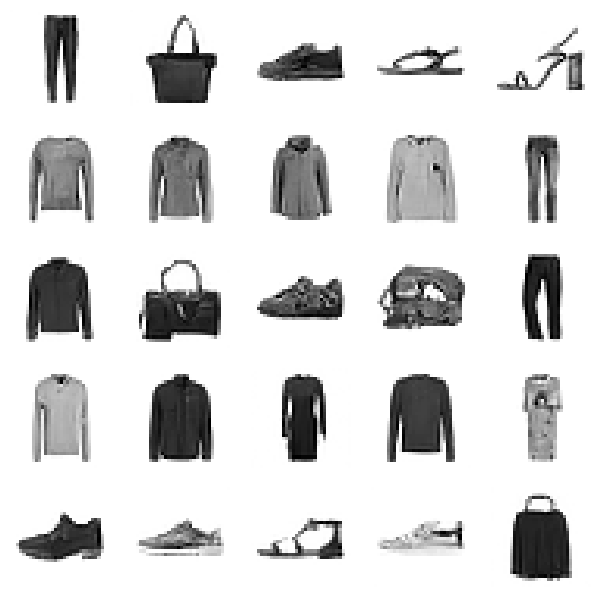

In [16]:
show_images(s[:25], imsize=1.5)

In [17]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [18]:
clean_mem()

In [20]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 1024 # Halving the BS
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb, yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [21]:
ie.fid(s), ie.kid(s)

(7.05145263671875, 0.03046184405684471)

In [22]:
ie.fid(xb), ie.kid(xb)

(3.39752197265625, 0.0018691789591684937)

Using a smaller BS results in 2x increase (degradation in this case) in FID score.

## **Pre-Built Diffusers DDIM Scheduler**

For DDIM, we will carry out 1/3rd of the steps when compared to DDPM. Which is pretty similar to the skip sampling approach we used in the previous NB. However, the implementation in Diffusers is much more sophisticated.

In [23]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [24]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [25]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1, 1)

The DDIM scheduler is almost 4x faster than DDPM's version.

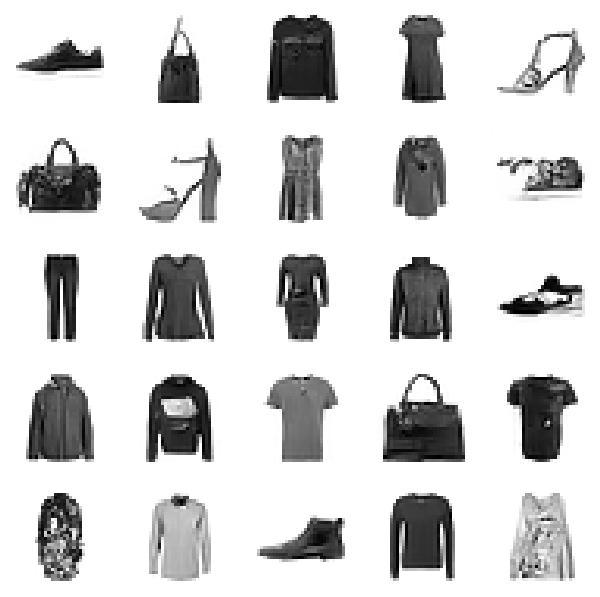

In [26]:
show_images(s[:25], imsize=1.5)

In [27]:
ie.fid(s), ie.kid(s)

(4.929931640625, 0.008650983683764935)

We can iteratively reduce the number of timesteps to assess the impact on generative performance.

In [28]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1, 1)
ie.fid(s), ie.kid(s)

(9.33636474609375, 0.015445845201611519)

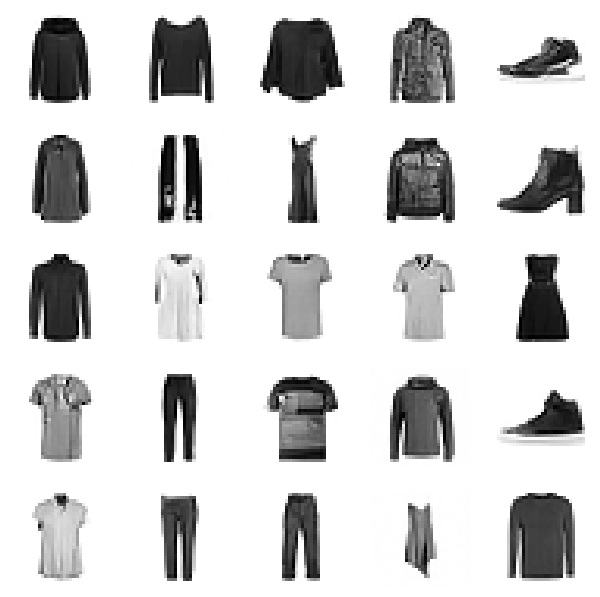

In [29]:
show_images(s[:25], imsize=1.5)

In [30]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [31]:
s = (preds[-1]*2).clamp(-1, 1)

In [32]:
ie.fid(s), ie.kid(s)

(8.0404052734375, 0.0026093777269124985)

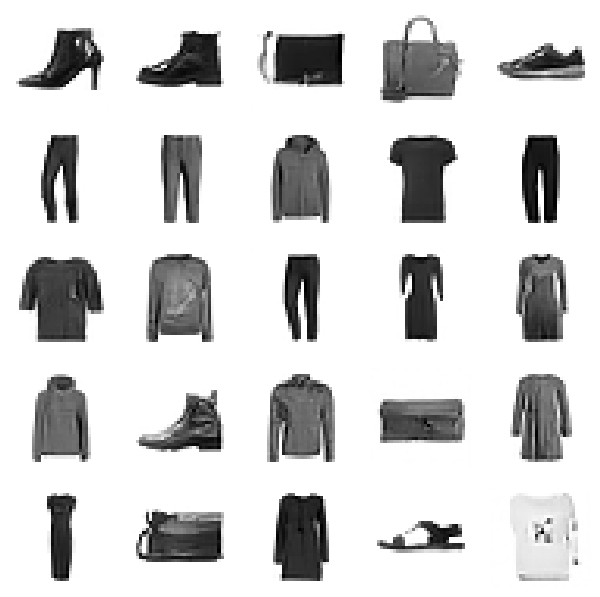

In [33]:
show_images(s[:25], imsize=1.5)

In [34]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(15.87493896484375, 0.06984836608171463)

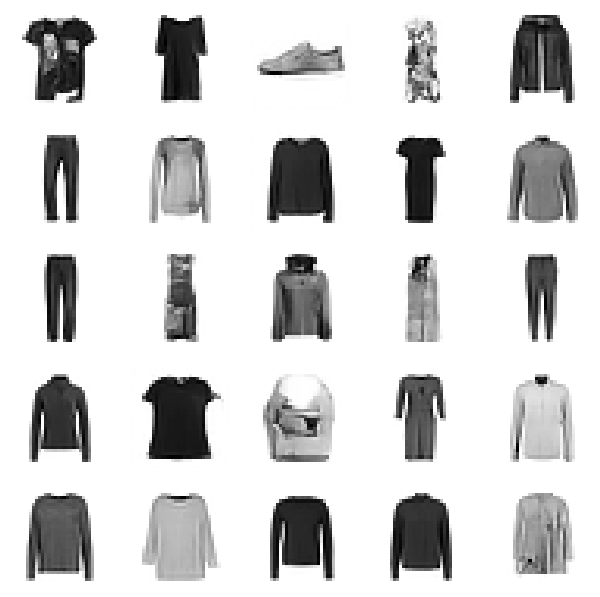

In [35]:
show_images(s[:25], imsize=1.5)

In [36]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(19.16455078125, 0.07935589551925659)

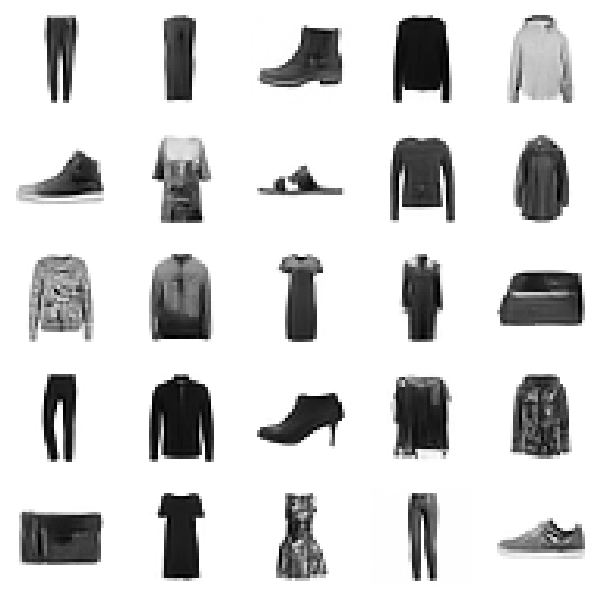

In [37]:
show_images(s[:25], imsize=1.5)

## **Implementing DDIM From Scratch**

In [38]:
from types import SimpleNamespace

In [39]:
n_steps = 1000

In [40]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [41]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

We can take the DDPM sampling function and split it into two sections:
1. A function which handles the DDIM steps.
2. Another function which handles the DDIM sampling.

The function `ddim_step()` is based on the following equation from the paper:

![title](imgs/ddim_equation.png)

An important, and slightly annoying fact to remember here is that the DDPM paper's `alpha bar` is called `alpha` in the DDIM paper.

In [42]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    # Based on the equation, sq.root of 1-alpha is called beta bar (bbar) here
    # noise is the neural net. Thus giving us the predicted x_0
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt()) 
    # Taking alpha bar-t1, the predicted x_0 and the factoring in the 
    # "direction pointing to x_t" segment
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t) # Random noise
    return x_t

In [45]:
@torch.no_grad()
def sample_ddim(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i, t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t>0 else torch.tensor(1)
        noise = model(x_t, t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

We can speed things up by skipping sequentially skipping 10 steps.

In [46]:
%%time
samples = sample_ddim(ddim_step, model, sz, 1000, 10)

CPU times: user 49.5 s, sys: 222 ms, total: 49.8 s
Wall time: 48.3 s


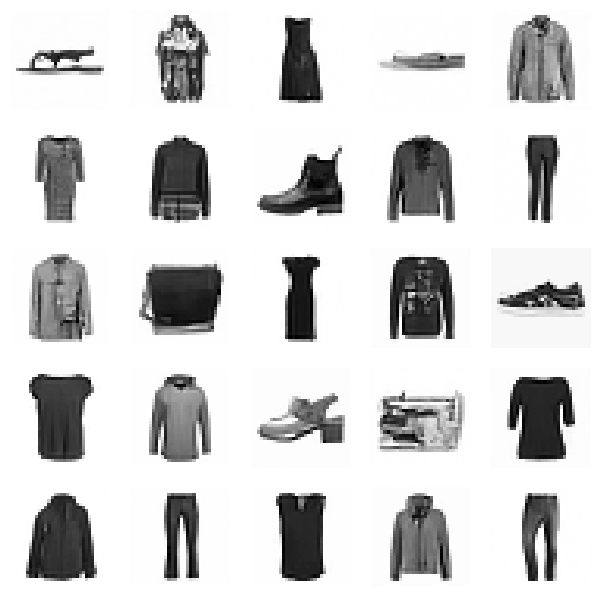

In [48]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)

In [49]:
ie.fid(s), ie.kid(s)

(8.78814697265625, 0.02383255958557129)